# Лабораторная работа №1

## 1.1. Генерация случайных квантовых состояний 

Представляем квантовое состояние в виде тензора $\psi_{ij}$, где $i$ - индекс первой подсистемы, $j$ - индекс второй подсистемы (вспомогательной).

Генерируем его случайным образом:
$\psi_{ij} = \dfrac{\varphi_{ij}}{\sum_{i, j} \varphi_{ij} \varphi^{*}_{ij}}$, где $\varphi_{ij} = \mathcal{N}(0, 1) + i \mathcal{N}(0, 1)$.

Из полученного состояния общей системы находим матрицу плотности общей системы:
$\rho_{i_1 j_1 i_2 j_2} = \psi_{i_1 j_1} \psi^{*}_{i_2 j_2}$.

Затем вычисляем частичный след по индексам, отвечающим вспомогательной квантовой системе, которая имеет размерность $k$ и получаем матрицу плотности исходной квантовой системы:
$\rho_{i_1 i_2} = \sum_{j = 1}^{k} \rho_{i_1 j i_2 j}$.

In [1]:
import numpy as np

In [2]:
class State(object):
    def __init__(self):
        self.state = None
        self.dim = None
        self.phys_ind = []

    def get_state(self):
        return self.state

    def gen_random_state(self, d, k):
        self.dim = d * k
        self.phys_ind = [d, k]
        self.state = np.random.randn(*self.phys_ind) + 1j * np.random.randn(*self.phys_ind)
        self.state = self.state / np.sqrt(np.sum(self.state * np.conjugate(self.state)))

    def get_random_sub_rho(self, d, k):
        state = np.reshape(self.state, [1, d, k, 1])
        global_rho = np.tensordot(state, np.conjugate(state), axes=([3], [0]))
        global_rho = np.reshape(global_rho, [d, k, d, k])
        rho = np.trace(global_rho, axis1=1, axis2=3)
        return rho

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

Сгенерируем $10000$ случайных смешанных состояний размерности $d$
и параметром $k$ с использованием процедуры очищения.

In [4]:
d = 5
k = 3

In [5]:
state = State()
state.gen_random_state(d, k)

eigen_list = []
for i in range(10000):
    state.gen_random_state(d, k)
    rho = state.get_random_sub_rho(d, k)
    s, u = np.linalg.eig(rho)
    eigen_list += list(s)

eigen_list = np.array(list(map(lambda x: x.real, eigen_list)))

Построим гистограмму распределения собственных значений матрицы плотности.

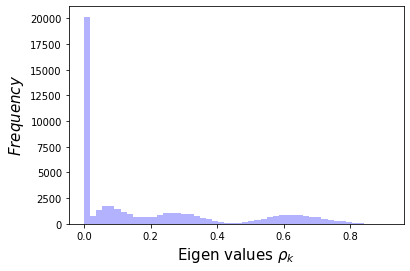

In [6]:
plt.hist(eigen_list, bins=50, color='blue', alpha=0.3)
plt.xlabel(r'Eigen values $\rho_k$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

Построим график зависимости среднего $Purity = \operatorname{Tr}\rho^2$ состояния от параметра $k$, изменяемого в пределах от $1$ до $100$. Для каждого значения $k$ генерируем $50$ смешанных состояний размерности $d$ с использованием процедуры очищения.

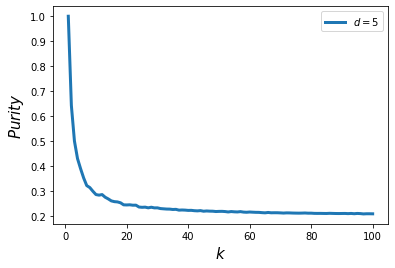

In [7]:
state = State()

k_list = []
purity_list = []
for k in range(1, 101, 1):
    purity = []
    for i in range(50):
        state.gen_random_state(d, k)
        rho = state.get_random_sub_rho(d, k)
        purity.append(np.trace(np.dot(rho, rho)))
    k_list.append(k)
    purity = np.array(purity)
    purity_list.append(purity.mean())

k_list = np.array(k_list)
purity_list = np.real(np.array(purity_list))

fig, ax = plt.subplots()
plt.plot(k_list, purity_list, lw=3, alpha=1, label=r'$d = 5$')
plt.legend(loc='upper right')
ax.minorticks_off()
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$Purity$', fontsize=15)
plt.show()

## 1.2. Разложение Шмидта и процедура очищения 

Снова представляем состояние в виде тензора $\psi_{ab}$, где $a$ - индекс первой подсистемы $A$, а $b$ - индекс второй подсистемы $B$.

Тензор $\psi_{ab}$ представляет собой матрицу $\Psi$.

In [8]:
class QubitState(object):
    def __init__(self):
        self.N = None
        self.state = None
        self.phys_ind = []

    def get_state(self):
        return self.state

    def all_zeros_state(self, n):
        self.N = n
        self.phys_ind = []
        state_qubit = np.reshape(np.array([1, 0], dtype=complex), [1, 2, 1])
        self.state = state_qubit
        self.phys_ind.append(2)
        for i in range(1, n, 1):
            self.state = np.tensordot(self.state, state_qubit, axes=([-1], [0]))
            self.phys_ind.append(2)
        self.state = self.state.reshape(self.phys_ind)

    def all_zeros_coeff(self, n):
        self.N = n
        self.phys_ind = [2] * self.N
        self.state = np.zeros(self.phys_ind)

    def get_rho_subsystem(self, da, db):
        state = np.reshape(self.state, [1, da, db, 1])
        global_rho = np.tensordot(state, np.conjugate(state), axes=([3], [0]))
        global_rho = np.reshape(global_rho, [da, db, da, db])
        rho_a = np.trace(global_rho, axis1=1, axis2=3)
        rho_b = np.trace(global_rho, axis1=0, axis2=2)
        return rho_a, rho_b

Создаём необходимое состояние $\psi_{i_1 i_2 i_3 i_4}$.

In [9]:
n = 4

state = QubitState()
state.all_zeros_coeff(n)

state.state[0, 0, 0, 1] = np.sqrt(11) / 8
state.state[0, 0, 1, 1] = -3 / 8
state.state[0, 1, 1, 1] = np.sqrt(10) / 8
state.state[1, 1, 1, 1] = np.sqrt(34) / 8

Представляем его в виде тензора $\psi_{ab}$ (группируем индексы 1-го и 2-го кубитов, а также 3-го и 4-го кубитов).

Затем производим сингулярное разложение матрицы $\Psi$:
$\Psi = U S V^{\dagger}$.

In [10]:
psi = np.reshape(state.state, (4, 4))

u, s, vh = np.linalg.svd(psi, full_matrices=True)

Проверяем, что разложение провели правильно.

In [11]:
print(psi - np.dot(u, np.dot(np.diag(s), vh)))

[[ 0.00000000e+00 -5.55111512e-17  0.00000000e+00  1.11022302e-16]
 [ 0.00000000e+00 -2.22343669e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.13846288e-16  0.00000000e+00  2.22044605e-16]]


Тогда столбцы матрицы $U$ - это новый базис в пространстве подсистемы $A$, а строки матрицы $V^{\dagger}$ - новый базис в пространстве подсистемы $B$.

list_vec_A - список состояний нового базиса в $A$.

list_vec_B - список состояний нового базиса в $B$.

s - список сингулярных значений $\sqrt{\lambda_k}$.

In [12]:
list_vec_A = [u.T[0], u.T[1], u.T[2], u.T[3]]
list_vec_B = [vh[0], vh[1], vh[2], vh[3]]

Проверим, что действительно получается исходное состояние $|\psi\rangle$, если записать $|\psi\rangle = \sum_{k} \sqrt{\lambda_k} |k_a\rangle |k_b\rangle$.

In [13]:
psi_new = np.zeros((1, 4, 4, 1))
for k in range(4):
    psi_a_k = np.reshape(list_vec_A[k], (1, 4, 1))
    psi_b_k = np.reshape(list_vec_B[k], (1, 4, 1))
    psi_new += s[k] * np.tensordot(psi_a_k, psi_b_k, axes=([2], [0]))
psi_new = np.reshape(psi_new, (4, 4))
print(psi_new - psi)

[[ 0.00000000e+00  1.11022302e-16  0.00000000e+00 -1.11022302e-16]
 [ 0.00000000e+00  2.22044605e-16  0.00000000e+00 -5.55111512e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16  0.00000000e+00 -2.22044605e-16]]


Получаем исходя из формул $\rho_A = \Psi \Psi^{\dagger}$ и $\rho_B = (\Psi^{\dagger} \Psi)^T$ матрицы плотности подсистем.

In [14]:
rho_A_svd = np.dot(u, np.dot(np.diag(s) ** 2, np.conjugate(u).T))
rho_B_svd = np.dot(np.conjugate(vh).T, np.dot(np.diag(s) ** 2, vh)).T

$\rho_A$

In [15]:
print(rho_A_svd)

[[ 0.3125     -0.14823177  0.         -0.27332587]
 [-0.14823177  0.15625     0.          0.28811076]
 [ 0.          0.          0.          0.        ]
 [-0.27332587  0.28811076  0.          0.53125   ]]


$\rho_B$

In [16]:
print(rho_B_svd)

[[ 0.          0.          0.          0.        ]
 [ 0.          0.171875    0.         -0.15546679]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.15546679  0.          0.828125  ]]


Сравниваем с взятием частичного следа.

In [17]:
rho_A_contraction, rho_B_contraction = state.get_rho_subsystem(4, 4)

$\rho_A$

In [18]:
print(rho_A_contraction)

[[ 0.3125     -0.14823177  0.         -0.27332587]
 [-0.14823177  0.15625     0.          0.28811076]
 [ 0.          0.          0.          0.        ]
 [-0.27332587  0.28811076  0.          0.53125   ]]


$\rho_B$

In [19]:
print(rho_B_contraction)

[[ 0.          0.          0.          0.        ]
 [ 0.          0.171875    0.         -0.15546679]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.15546679  0.          0.828125  ]]


Вычисляем число Шмидта $K = \dfrac{1}{\sum_k \lambda^2_k}$.

In [20]:
K = 1 / np.sum(s ** 4)
print('K = ', K)
print('Norma = ', np.sum(s ** 2))

K =  1.3094629156010233
Norma =  0.9999999999999999


Вычисляем Negativity: $Negativity = \sum_k \dfrac{|\lambda_k| - \lambda_k}{2}$, где $\lambda_k$ - собственные значения частично траспонированной матрицы плотности всей системы $\rho$.

In [21]:
psi = np.reshape(state.state, [1, 4, 4, 1])
rho_AB = np.tensordot(psi, np.conjugate(psi), axes=([3], [0]))
rho_AB = np.reshape(rho_AB, [4, 4, 4, 4])
global_rho_partial_transpose_A = np.transpose(rho_AB, axes=(2, 1, 0, 3))
global_rho_partial_transpose_B = np.transpose(rho_AB, axes=(0, 3, 2, 1))

eig_A = np.linalg.eig(global_rho_partial_transpose_A)[0]
eig_B = np.linalg.eig(global_rho_partial_transpose_B)[0]

negativity_A = 0.5 * np.sum(np.abs(eig_A) - eig_A)
negativity_B = 0.5 * np.sum(np.abs(eig_B) - eig_B)

print(negativity_A)
print(negativity_B)

0.10944948754428743
0.10944948754428743


Убедимся, что случайно сгенерированное чистое 4-ёх кубитное состояние почти всегда имеет ненулевую меру запутанности ($K$ и $Negativity$). В качестве подсистемы A выберем первые два кубита, в качестве подсистемы B - последние два кубита.

In [22]:
K_list = []
Negativity_list = []
state = State()
for i in range(100000):
    state.gen_random_state(4, 4)
    psi = state.state
    u, s, vh = np.linalg.svd(psi, full_matrices=True)
    K_list.append(1 / np.sum(s ** 4))

    psi = np.reshape(state.state, [1, 4, 4, 1])
    rho_AB = np.tensordot(psi, np.conjugate(psi), axes=([3], [0]))
    rho_AB = np.reshape(rho_AB, [4, 4, 4, 4])
    global_rho_partial_transpose_A = np.transpose(rho_AB, axes=(2, 1, 0, 3))
    eig_A = np.linalg.eig(global_rho_partial_transpose_A)[0]
    negativity_A = 0.5 * np.sum(np.abs(eig_A) - eig_A)
    Negativity_list.append(negativity_A)

K_list = np.array(list(map(lambda x: x.real, K_list)))
Negativity_list = np.array(list(map(lambda x: x.real, Negativity_list)))

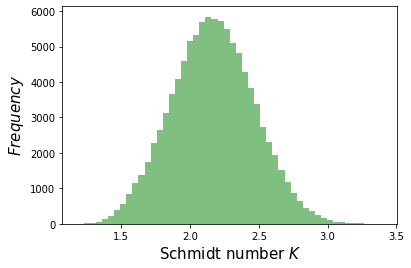

In [23]:
plt.hist(K_list, bins=50, color='green', alpha=0.5)
plt.xlabel(r'Schmidt number $K$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

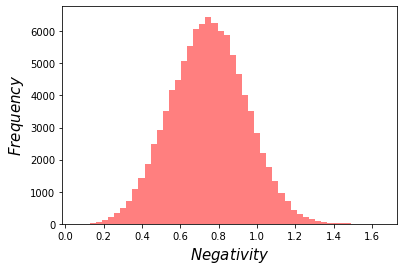

In [24]:
plt.hist(Negativity_list, bins=50, color='red', alpha=0.5)
plt.xlabel(r'$Negativity$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()